In [1]:

%load_ext autoreload
%autoreload 2
import common.utils as utils
import common.analysis as analysis
import pandas as pd
import seaborn as sns
import os
import numpy as np
import common.lazy as lazy
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
functionName = "go-io-breakpoint"
definition = utils.getBenchmarkDefinition(functionName)
outputFolder = f"output/{definition['name']}"
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
runs = [lazy.getResultSummary(f"{definition['name']}-breakpoint-{r}","1") for r in range(1,4)]

In [3]:
httpsStats1 = [analysis.withLoadGrouping(lazy.getHttRequestStats(f"{definition['name']}-breakpoint-{index}", "1")) for index, run in enumerate(runs, start=1)]
for ind, df in enumerate(httpsStats1):
    df["run"] = ind
httpStats1 = pd.concat(httpsStats1)


<Axes: xlabel='time', ylabel='value'>

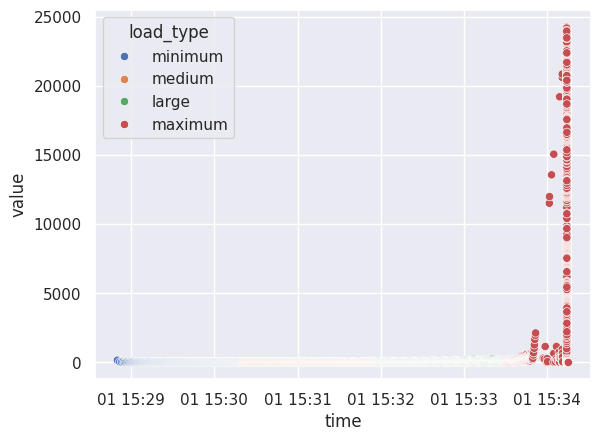

In [4]:
stats = httpStats1.query("run == 0")
sns.scatterplot(data=stats, x='time', y='value', hue='load_type')

In [5]:
summary_table = analysis.latencyDistributionByThroughputGroup(httpStats1)
summary_table["replicas"] = 1
styled = summary_table.style.format(precision=2).hide().hide(["replicas", "min_load", "max_load"], axis=1)
styled.to_latex(f"{outputFolder}/summary_table_{definition['docker_image_name']}.tex",  caption=f"Summary table for response time metrics for \\textit{{{definition['docker_image_name']}}}", label=f"tab:summary_table_{definition['docker_image_name']}", position="h", position_float="centering", hrules=True)
styled

throughput,mean,std,p50,p90,p95,p99,error rate,rps
minimum,23.68,8.18,22.15,26.92,30.29,53.97,0.00,0.0-10.0
medium,25.21,10.45,21.91,30.23,53.55,70.35,0.00,10.0-21.0
large,47.34,37.18,24.79,97.17,126.37,174.54,0.00,21.0-31.0
maximum,4085.45,6886.21,298.01,16862.38,20565.41,23463.54,0.41,31.0-35.0


In [6]:
httpsStats8 = [analysis.withLoadGrouping(lazy.getHttRequestStats(f"{definition['name']}-breakpoint-{index}", "8")) for index, run in enumerate(runs, start=1)]
httpStats8 = pd.concat(httpsStats8)
summary_table8 = analysis.latencyDistributionByThroughputGroup(httpStats8)
summary_table8["replicas"] = 8

In [7]:
httpsStats16 = [analysis.withLoadGrouping(lazy.getHttRequestStats(f"{definition['name']}-breakpoint-{index}", "16")) for index, run in enumerate(runs, start=1)]
httpStats16 = pd.concat(httpsStats16)
summary_table16 = analysis.latencyDistributionByThroughputGroup(httpStats16)
summary_table16["replicas"] = 16


In [8]:
httpsStats32 = [analysis.withLoadGrouping(lazy.getHttRequestStats(f"{definition['name']}-breakpoint-{index}", "32")) for index, run in enumerate(runs, start=1)]
httpStats32 = pd.concat(httpsStats32)
summary_table32 = analysis.latencyDistributionByThroughputGroup(httpStats32)
summary_table32["replicas"] = 32

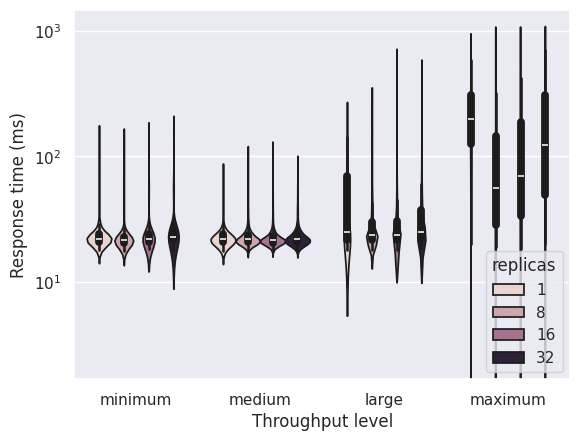

In [ ]:
allStats = pd.concat([httpStats1, httpStats8, httpStats16, httpStats32]).query("is_error == False")
boxPlot = sns.boxplot(x="load_type", y="value", hue="replicas", data=allStats)
boxPlot.set_yscale("log")
boxPlot.set(xlabel="Throughput level", ylabel="Response time (ms)")
plt.savefig(f"{outputFolder}/profiling_bench_response_times_{definition['docker_image_name']}.png")

In [ ]:
combinedTable = pd.concat([summary_table, summary_table8, summary_table16, summary_table32])
combinedTable.set_index(["throughput", "replicas", "rps"], inplace=True)
combinedTable.sort_index(inplace=True)
styled = combinedTable.style.format(precision=2).hide(["min_load", "max_load"], axis=1)
styled.to_latex(f"{outputFolder}/summary_table_{definition['docker_image_name']}_multi.tex",  caption=f"Summary table for response time metrics for \\textit{{{definition['docker_image_name']}}}", label=f"tab:summary_table_{definition['docker_image_name']}", position="h", position_float="centering", hrules=True)
styled

In [ ]:
from scipy import stats
import json

allHttpStats = pd.concat([httpStats1, httpStats8, httpStats16, httpStats32]).query("is_error == False")
responseDistributions = [
  {
    "s": s,
    "loc": loc,
    "scale": scale,
  } for s, loc, scale in [stats.lognorm.fit(allHttpStats.query(f"load_type == '{load_type}'")["value"]) for load_type in ["minimum", "medium", "large"]]
]
output_file_path = os.path.join(outputFolder, 'function_profile.json')
print(f"Writing function profile to {output_file_path}")
with open(output_file_path, 'w') as f:
  json.dump({
    "functionName": functionName,
    "responseDistributions": responseDistributions
  }, f)


Writing function profile to output/go-io/function_profile.json


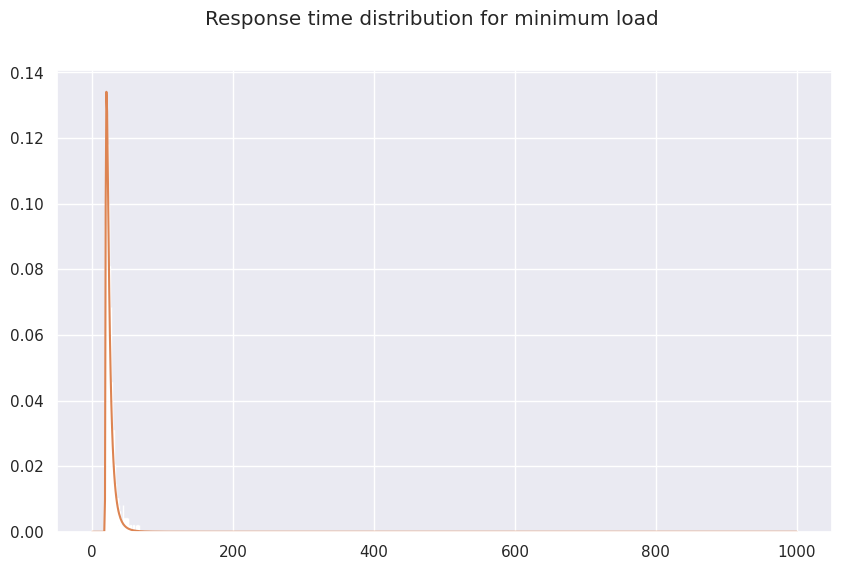

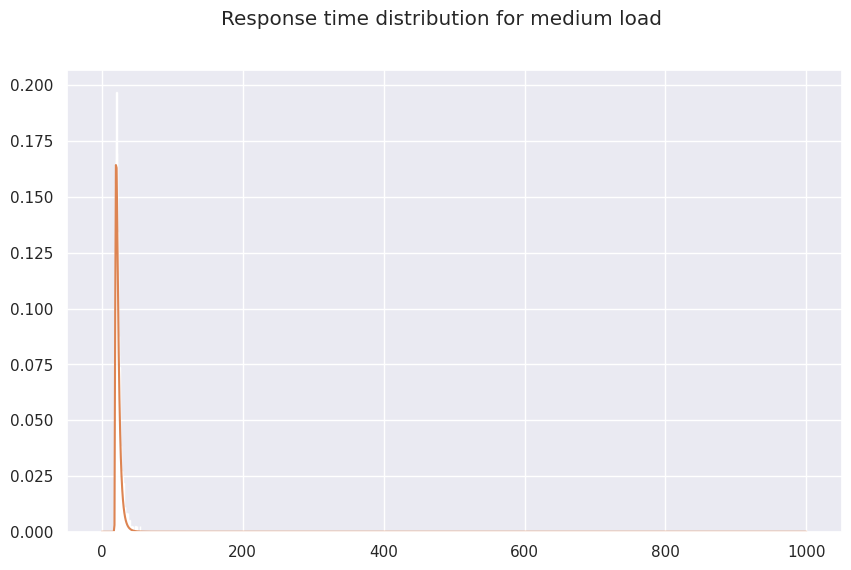

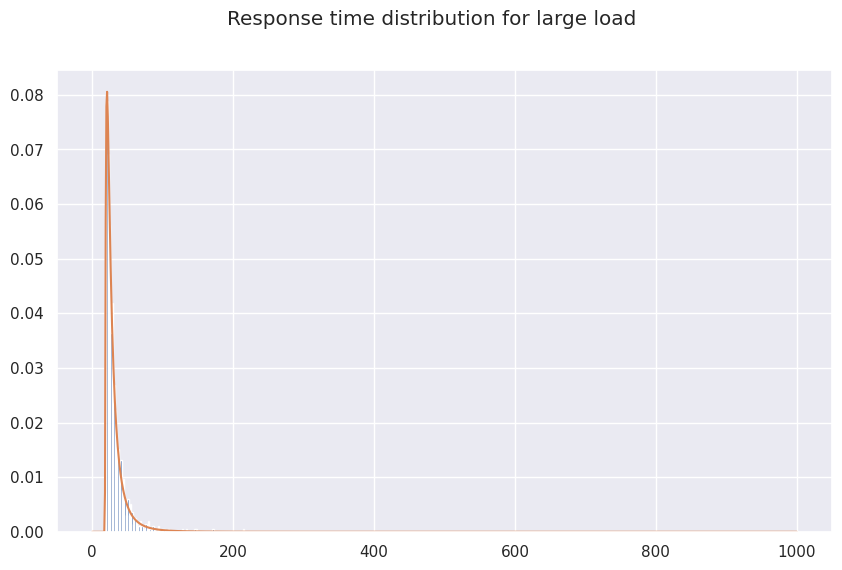

In [ ]:
for index, load_type in enumerate(["minimum", "medium", "large"]):
  fig, ax = plt.subplots(figsize=(10, 6))
  fig.suptitle(f"Response time distribution for {load_type} load")
  Y = stats.lognorm(*responseDistributions[index].values())
  x = np.linspace(0, 1000, 1000)
  y = Y.rvs(1000)
  ax.hist(y, bins=100, density=True)
  pdf = stats.lognorm.pdf(x, *responseDistributions[index].values())
  plt.plot(x, pdf)